In [1]:
import cv2
import open3d as o3d
import numpy as np
import laspy
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class CameraCalibration:
    ext_L2R = np.eye(4)
    # TcL2cR 
    def __init__(
        self,
        fx, fy, cx, cy,
        k1, k2, p1, p2,
        width, height
        ):
        """
        Args:
			fx, fy, cx, cy
			k1, k2, p1, p2
			width, height
        """
        self.fx, self.fy, self.cx, self.cy = fx, fy, cx, cy
        self.k1, self.k2, self.p1, self.p2 = k1, k2, p1, p2
        self.width, self.height = width, height
        self.img_size = (width, height)
        
        # Instrinsics
        self.K , self.iK = self.setup_intrins(fx,fy,cx,cy)
        self.ifx, self.ify, self.icx, self.icy = self.iK[0,0], self.iK[0,2], self.iK[1,1], self.iK[1,2] 
        
        # Distortion
        self.D = np.array([k1,k2,p1,p2])

        
        return
    
    def setup_intrins(self,fx,fy,cx,cy):
        k = np.eye(3)
        k[0,0], k[0,2], k[1,1], k[1,2] = fx, cx, fy, cy
        ik = np.linalg.inv(k)
        return k, ik
    
    def setup_extrinsic(self, extL, extR):
        self.ext_L2R = np.linalg.inv(extL) @ extR
        self.ext_R2L = np.linalg.inv(self.ext_L2R)
        self.T_l2r, self.T_r2l = self.ext_L2R[0:3,3], self.ext_R2L[0:3,3]
        self.R_l2r, self.R_r2l = self.ext_L2R[0:3,0:3], self.ext_R2L[0:3,0:3]
        
    def setup_undistortStereoMap(self, R, P, roi):
        self.xmap, self.ymap = cv2.initUndistortRectifyMap(self.K, self.D, R, P, self.img_size, cv2.CV_32FC1)
    
    def rectify_image(self, img):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        return cv2.remap(img, self.xmap, self.ymap, cv2.INTER_LINEAR)
        
    
ExtLeft = np.array([
    [0.0148655429818, -0.999880929698, 0.00414029679422, -0.0216401454975,],
	[0.999557249008, 0.0149672133247, 0.025715529948,  -0.064676986768,],
	[-0.0257744366974, 0.00375618835797, 0.999660727178, 0.00981073058949,],
	[0., 0., 0., 1.],
	])
ExtRight = np.array([
    [0.0125552670891, -0.999755099723, 0.0182237714554, -0.0198435579556,],
    [0.999598781151, 0.0130119051815, 0.0251588363115, 0.0453689425024,],
    [-0.0253898008918, 0.0179005838253, 0.999517347078, 0.00786212447038,],
    [0., 0., 0., 1.]
    ])

# Setup Calibration
calibCamLeft = CameraCalibration(
    fx = 458.654, fy =457.296, cx=367.215, cy = 248.375, 
    k1=-0.28340811, k2=0.07395907, p1=0.00019359, p2=1.76187114e-05, 
    width=752, height=480
    )
calibCamRight = CameraCalibration(
    fx = 457.587, fy =456.134, cx=379.999, cy = 255.238, 
    k1=-0.28368365, k2=0.07451284, p1=-0.00010473, p2=-3.555907e-05, 
    width=752, height=480
    )
calibCamRight.setup_extrinsic(ExtLeft,ExtRight)

# Setup Stereo Calibration

# camera -> Rectification -> Disparity map -> Depth perception. 



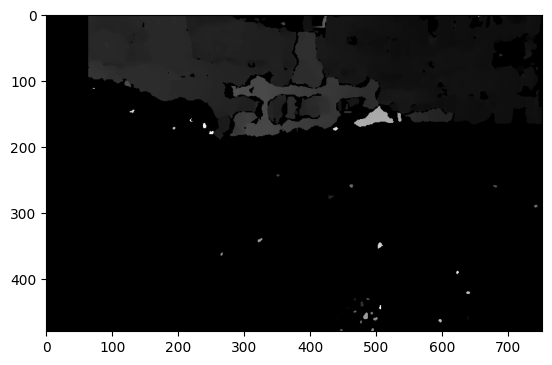

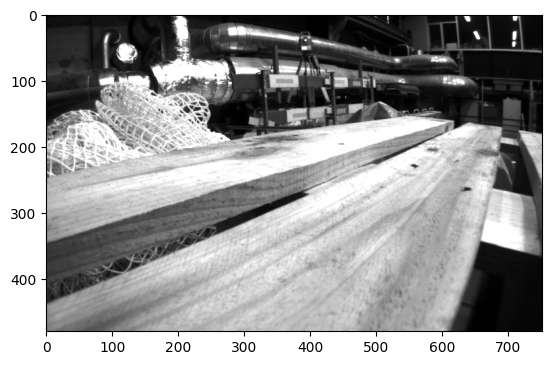

[[   1.            0.            0.         -364.44123459]
 [   0.            1.            0.         -256.95167542]
 [   0.            0.            0.          436.24429565]
 [   0.            0.            9.0844804    -0.        ]]


In [16]:
class StereoCalibration:
    def __init__(self, cam_Left:CameraCalibration, cam_Right:CameraCalibration):
        self.cam_Left, self.cam_Right = cam_Left, cam_Right
        Rleft, Rright, PL, PR, Q, rectLeft, rectRight = \
            cv2.stereoRectify(
                cam_Left.K, cam_Left.D, 
                cam_Right.K, cam_Right.D,
                cam_Right.img_size, 
                cam_Right.R_r2l, cam_Right.T_r2l,
                alpha=0
                )
        # https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6
        self.R_left, self.R_right = Rleft, Rright
        self.P_left, self.P_right = PL, PR
        self.rect_left, self.rect_right = rectLeft, rectRight
        self.Q = Q
        self.setupstereoRectification()
        self.stereo = self.setup_cv2Stereo()

        pass
    
    def setupstereoRectification(self):
        self.cam_Left.setup_undistortStereoMap(self.R_left, self.P_left, self.rect_left)
        self.cam_Right.setup_undistortStereoMap(self.R_right, self.P_right, self.rect_right)
        pass
    
    def rectifyImg(self, img_left, img_right):
        img_left_rectified = self.cam_Left.rectify_image(img_left)
        img_right_rectified = self.cam_Right.rectify_image(img_right)
        return img_left_rectified, img_right_rectified
    
    def calc_disparity(self, img_left, img_right):
        img_left, img_right = self.rectifyImg(img_left, img_right)
        
        disparity = self.stereo.compute(img_left,img_right).astype(np.float32)
        disparity = (disparity/16.0 - self.minDisparity)/self.numDisparities
        disparity[disparity<=0]=0
        disparity[disparity>=0.9]=0
        # disparity = cv2.normalize(disparity,0,255,cv2.NORM_MINMAX)
        
        img_3d = cv2.reprojectImageTo3D(disparity=disparity, Q=self.Q,handleMissingValues=True)
        img_3d = img_3d.reshape(img_3d.shape[0]*img_3d.shape[1], 3)

        mask = ~np.isinf(img_3d).any(axis=1) 
        img_3d = img_3d[mask]

        return disparity, img_3d
    
    def setup_cv2Stereo(self):
        cv2stereo = cv2.StereoSGBM_create()
        self.minDisparity = 0
        self.numDisparities = 64
        cv2stereo.setNumDisparities(self.numDisparities)
        cv2stereo.setBlockSize(10)
        # cv2stereo.setPreFilterType(1)
        # cv2stereo.setPreFilterSize(3*2 + 5)
        cv2stereo.setPreFilterCap(100)
        # cv2stereo.setTextureThreshold(30)
        cv2stereo.setUniquenessRatio(30)
        cv2stereo.setSpeckleRange(8)
        cv2stereo.setSpeckleWindowSize(10)
        cv2stereo.setDisp12MaxDiff(1)
        cv2stereo.setMinDisparity(self.minDisparity)
        return cv2stereo
        

stereo = StereoCalibration(calibCamLeft, calibCamRight)
img_left = cv2.imread("mav0/cam0/data/1403637130538319104.png")
img_right = cv2.imread("mav0/cam1/data/1403637130538319104.png")
disparity, img_3d = stereo.calc_disparity(img_left, img_right)
plt.imshow(disparity,'gray')
plt.show()
plt.imshow(img_left)
plt.show()
print(stereo.Q)

In [17]:

def save_pcd(pcd, filename):
    header = laspy.LasHeader(point_format=7, version="1.4")
    las = laspy.LasData(header)
    # las.x, las.y, las.z = pcd[:,0], pcd[:,1], pcd[:,2]
    las.y, las.z, las.x = pcd[:,0], pcd[:,1], -pcd[:,2]
    las.write(filename)

save_pcd(img_3d, "test.las")